<a href="https://colab.research.google.com/github/WinterBlossom0/Machine-Learning-practice/blob/main/nsdc_animal_condition_classification_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Milestone 1: Importing Libraries and Dataset 📚 📥**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
from itertools import product
import matplotlib.pyplot as plt
import umap
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
from imblearn.over_sampling import SVMSMOTE
from sklearn.model_selection import StratifiedShuffleSplit
import optuna
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/data.csv')
df.head()

,AnimalName,symptoms1,symptoms2,symptoms3,symptoms4,symptoms5,Dangerous
0,Dog,Fever,Diarrhea,Vomiting,Weight loss,Dehydration,Yes
1,Dog,Fever,Diarrhea,Coughing,Tiredness,Pains,Yes
2,Dog,Fever,Diarrhea,Coughing,Vomiting,Anorexia,Yes
3,Dog,Fever,Difficulty breathing,Coughing,Lethargy,Sneezing,Yes
4,Dog,Fever,Diarrhea,Coughing,Lethargy,Blue Eye,Yes


In [ ]:
df.isnull().sum()

,0
AnimalName,0
symptoms1,0
symptoms2,0
symptoms3,0
symptoms4,0
symptoms5,0
Dangerous,2


In [ ]:
df.iloc[:, 0].unique()

array(['Dog', 'cat', 'Rabbit', 'cow', 'chicken', 'cattle', 'mammal',
       'Cattle', 'Horse', 'Turtle', 'Hamster', 'Lion', 'Fox', 'Fox ',
       'Goat', 'Deer', 'Chicken', 'Monkey', 'Birds', 'Sheep', 'Pigs',
       'Fowl', 'Duck', 'Other Birds', 'snake', 'horse', 'duck', 'donkey',
       'Donkey', 'mules', 'Elephant', 'Elk', 'Wapiti', 'Mule deer',
       'Black-tailed deer', 'Sika deer', 'White-tailed deer', 'Reindeer',
       'Moos', 'Tiger', 'Goats', 'Buffaloes', 'Dogs', 'Wolves', 'Hyaenas',
       'Pig'], dtype=object)

In [ ]:
'''spell = SpellChecker()
tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-large-cased-v1.1")
model = BertForMaskedLM.from_pretrained("dmis-lab/biobert-large-cased-v1.1")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def correct_phrase(phrase, context="The animal is diagnosed with the symptom"):
    model = model.to(device)
    words = phrase.split()
    misspelled_words = [word for word in words if word.lower() not in spell]

    if not misspelled_words:
        return phrase  # If there are no misspelled words, return the original phrase

    # Create a dictionary of candidates for the misspelled words
    candidates_dict = {}
    for word in misspelled_words:
        candidates = spell.candidates(word)
        if candidates is None:
            candidates_dict[word] = [word]  # If no candidates, use the word itself
        else:
            candidates_dict[word] = list(candidates)  # Ensure candidates are a list

    # Filter function for candidates (currently just returns them as is)
    def filter_candidates(candidates):
        return candidates

    filtered_candidates_dict = {word: filter_candidates(candidates) for word, candidates in candidates_dict.items()}

    # Build a sentence template with placeholders for the misspelled words
    sentence_template = " ".join([word if word.lower() not in misspelled_words else '{}' for word in words])

    def evaluate_combination(candidate_combination):
        sentence = sentence_template
        for i, candidate in enumerate(candidate_combination):
            sentence = sentence.replace("{}", candidate, 1)

        # Use the context here for evaluation
        evaluation_sentence = f"{context} {sentence}"

        # Tokenize the sentence and feed it into the model
        inputs = tokenizer(evaluation_sentence, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits

        # Evaluate the score for the candidate combination
        score = 0
        for i, candidate in enumerate(candidate_combination):
            candidate_tokens = tokenizer.tokenize(candidate)
            candidate_ids = tokenizer.convert_tokens_to_ids(candidate_tokens)

            for candidate_id in candidate_ids:
                mask_indices = torch.where(inputs["input_ids"] == candidate_id)[1]
                for mask_index in mask_indices:
                    score += logits[0, mask_index, candidate_id].item()

        return sentence, score

    # Generate candidate combinations and evaluate them
    candidate_combinations = list(product(*filtered_candidates_dict.values()))

    if not candidate_combinations:
        return phrase

    scored_combinations = [
        evaluate_combination(combination) for combination in candidate_combinations
    ]

    # Rank the combinations based on the evaluation score
    ranked_combinations = sorted(scored_combinations, key=lambda x: x[1], reverse=True)

    best_sentence, best_score = ranked_combinations[0]
    return best_sentence  # Return the corrected sentence without context

# Example usage
corrected_phrase = correct_phrase("thigk skin")
print(f"Corrected phrase: {corrected_phrase}")
'''

'spell = SpellChecker()\ntokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-large-cased-v1.1")\nmodel = BertForMaskedLM.from_pretrained("dmis-lab/biobert-large-cased-v1.1")\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\ndef correct_phrase(phrase, context="The animal is diagnosed with the symptom"):\n    model = model.to(device)\n    words = phrase.split()\n    misspelled_words = [word for word in words if word.lower() not in spell]\n\n    if not misspelled_words:\n        return phrase  # If there are no misspelled words, return the original phrase\n\n    # Create a dictionary of candidates for the misspelled words\n    candidates_dict = {}\n    for word in misspelled_words:\n        candidates = spell.candidates(word)\n        if candidates is None:\n            candidates_dict[word] = [word]  # If no candidates, use the word itself\n        else:\n            candidates_dict[word] = list(candidates)  # Ensure candidates are a list\n\n    # Filter f

In [ ]:
df['symptoms1'].head()

,symptoms1
0,Fever
1,Fever
2,Fever
3,Fever
4,Fever


# **Milestone 2: Data Cleaning 🧹 🍃 and Pre-Processing ⏳**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.2")
model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.2")

columns_to_process = df.iloc[:, 1:6]
unique_symptoms = pd.unique(columns_to_process.values.ravel())
unique_symptoms = [symptom for symptom in unique_symptoms if str(symptom) != "nan"]

def get_embeddings(text_list):
    inputs = tokenizer(text_list, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

embeddings = get_embeddings(unique_symptoms)

cosine_sim = cosine_similarity(embeddings)

threshold = 0.9

clusters = []
visited = set()

for i, symptom in enumerate(unique_symptoms):
    if i not in visited:
        cluster = [symptom]
        visited.add(i)
        for j, sim in enumerate(cosine_sim[i]):
            if sim >= threshold and j != i and j not in visited:
                cluster.append(unique_symptoms[j])
                visited.add(j)
        clusters.append(cluster)

clustered_data = pd.DataFrame({
    "symptom": [item for sublist in clusters for item in sublist],
    "cluster": [i for i, sublist in enumerate(clusters) for _ in sublist]
})

symptom_to_cluster = dict(zip(clustered_data['symptom'], clustered_data['cluster']))

df_updated = df.copy()

for col in range(1, 6):
    df_updated.iloc[:, col] = df_updated.iloc[:, col].map(symptom_to_cluster)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
df_updated.head()

,AnimalName,symptoms1,symptoms2,symptoms3,symptoms4,symptoms5,Dangerous
0,Dog,0,1,0,1,1,Yes
1,Dog,0,1,0,1,2,Yes
2,Dog,0,1,0,0,1,Yes
3,Dog,0,3,0,1,0,Yes
4,Dog,0,1,0,1,4,Yes


In [ ]:
birds = ['chicken', 'fowl', 'duck', 'other birds', 'birds']
deers = ['deer', 'mule deer', 'black-tailed deer', 'sika deer', 'white-tailed deer', 'reindeer', 'wapiti', 'elk']

df_updated['AnimalName'] = df_updated['AnimalName'].str.lower()

df_updated['AnimalName'] = df_updated['AnimalName'].apply(
    lambda x: 'bird' if any(bird in x for bird in birds) else
              ('deer' if any(deer in x for deer in deers) else x)
)


In [ ]:
df_updated['AnimalName'].unique()

array(['dog', 'cat', 'rabbit', 'cow', 'bird', 'cattle', 'mammal', 'horse',
       'turtle', 'hamster', 'lion', 'fox', 'fox ', 'goat', 'deer',
       'monkey', 'sheep', 'pigs', 'snake', 'donkey', 'mules', 'elephant',
       'moos', 'tiger', 'goats', 'buffaloes', 'dogs', 'wolves', 'hyaenas',
       'pig'], dtype=object)

In [ ]:
df_topred = df_updated[df_updated.isna().any(axis=1)]
df_updated = df_updated.dropna()

In [ ]:
df_topred.head()

,AnimalName,symptoms1,symptoms2,symptoms3,symptoms4,symptoms5,Dangerous
269,sheep,4,0,1,1,1,NaN
695,buffaloes,4,0,1,1,1,NaN


In [ ]:
df_updated['Dangerous'] = df_updated['Dangerous'].str.strip().str.lower()
df_updated['Dangerous'] = df_updated['Dangerous'].map({'yes': 1, 'no': 0})


In [ ]:
df_updated = pd.get_dummies(df_updated, columns=['AnimalName'])
object_columns = df_updated.select_dtypes(include=['object']).columns
df_updated[object_columns] = df_updated[object_columns].apply(pd.to_numeric, errors='coerce')
df_updated.head()

,symptoms1,symptoms2,symptoms3,symptoms4,symptoms5,Dangerous,AnimalName_bird,AnimalName_buffaloes,AnimalName_cat,AnimalName_cattle,...,AnimalName_moos,AnimalName_mules,AnimalName_pig,AnimalName_pigs,AnimalName_rabbit,AnimalName_sheep,AnimalName_snake,AnimalName_tiger,AnimalName_turtle,AnimalName_wolves
0,0,1,0,1,1,1,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,1,0,1,2,1,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,1,0,0,1,1,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,3,0,1,0,1,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,1,0,1,4,1,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
X = df_updated.drop(columns = ['Dangerous'])
y = df_updated['Dangerous']

# **Milestone 3: Exploratory Data Analysis 🔎📊**

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


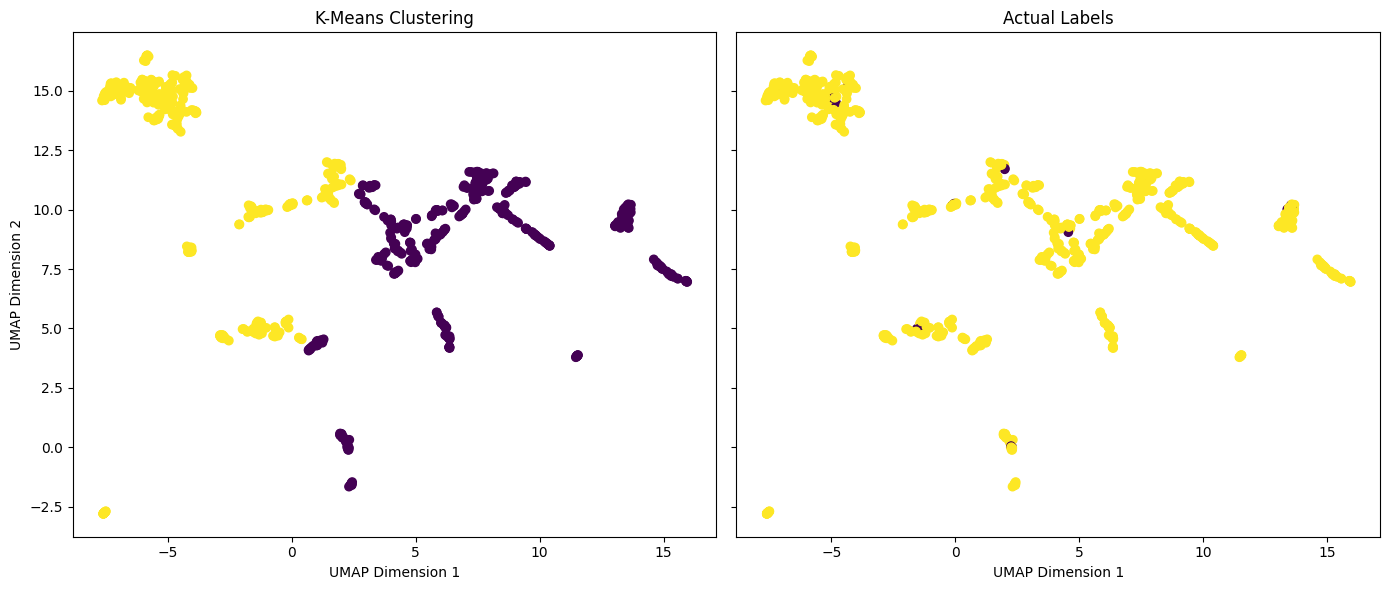

In [ ]:
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X)

kmeans_model = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans_model.fit_predict(X_umap)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

axes[0].scatter(X_umap[:, 0], X_umap[:, 1], c=kmeans_labels, cmap='viridis')
axes[0].set_title('K-Means Clustering')
axes[0].set_xlabel('UMAP Dimension 1')
axes[0].set_ylabel('UMAP Dimension 2')

axes[1].scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis')
axes[1].set_title('Actual Labels')
axes[1].set_xlabel('UMAP Dimension 1')

plt.tight_layout()
plt.show()

# **Milestone 4: Addressing Imbalanced Data 📉 ➡️ ⚖️**

In [ ]:
svm_smote = SVMSMOTE(sampling_strategy='auto', random_state=42)
X, y = svm_smote.fit_resample(X, y)

print("Category value distribution after SVMSMOTE:")
print(pd.Series(y).value_counts())


Category value distribution after SVMSMOTE:
Dangerous
1    849
0    476
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


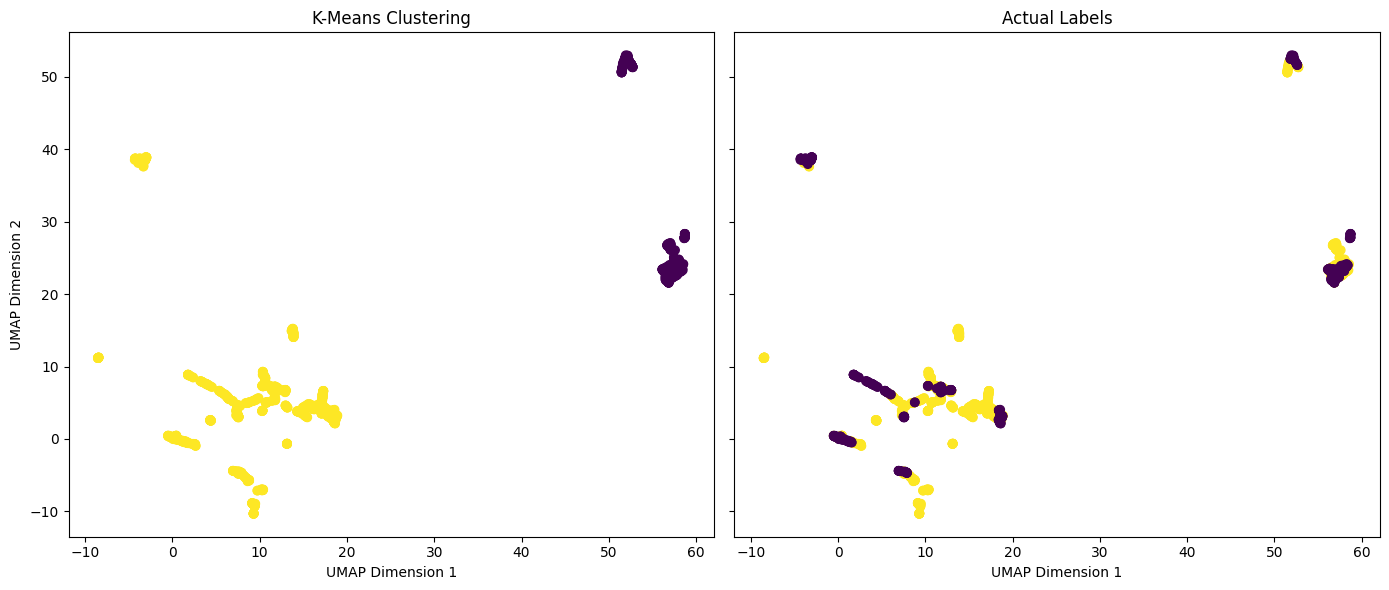

In [ ]:
X_umap = umap_model.fit_transform(X)

kmeans_model = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans_model.fit_predict(X_umap)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

axes[0].scatter(X_umap[:, 0], X_umap[:, 1], c=kmeans_labels, cmap='viridis')
axes[0].set_title('K-Means Clustering')
axes[0].set_xlabel('UMAP Dimension 1')
axes[0].set_ylabel('UMAP Dimension 2')

axes[1].scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis')
axes[1].set_title('Actual Labels')
axes[1].set_xlabel('UMAP Dimension 1')

plt.tight_layout()
plt.show()

# **Milestone 5: Model Training 🦾 🤖  using LightGBM ⚙️ 🪶**

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
X_train.head()

,symptoms1,symptoms2,symptoms3,symptoms4,symptoms5,AnimalName_bird,AnimalName_buffaloes,AnimalName_cat,AnimalName_cattle,AnimalName_cow,...,AnimalName_moos,AnimalName_mules,AnimalName_pig,AnimalName_pigs,AnimalName_rabbit,AnimalName_sheep,AnimalName_snake,AnimalName_tiger,AnimalName_turtle,AnimalName_wolves
260,5,5,4,1,12,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
492,0,2,1,2,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
335,1,3,1,1,0,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
686,0,10,0,3,0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1060,0,1,1,1,3,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'AUC',
        'boosting_type': 'gbdt',
        'device': 'cpu',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'verbose': -1
    }

    model = lgb.LGBMClassifier(**params)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    specificity_scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_valid_fold)

        spec = specificity(y_valid_fold, y_pred)
        specificity_scores.append(spec)

    return np.mean(specificity_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

best_params = study.best_params

model = lgb.LGBMClassifier(**best_params)
model.fit(X_train, y_train)

[I 2025-01-19 17:30:18,595] A new study created in memory with name: no-name-09ea51f3-c1ac-4e11-8be6-93addb154318
[I 2025-01-19 17:30:19,709] Trial 0 finished with value: 0.9448735475051265 and parameters: {'num_leaves': 31, 'max_depth': 9, 'learning_rate': 0.012526185603399452, 'n_estimators': 847, 'min_child_samples': 40, 'subsample': 0.9346666071051682, 'colsample_bytree': 0.5994787493283007}. Best is trial 0 with value: 0.9448735475051265.
[I 2025-01-19 17:30:20,097] Trial 1 finished with value: 0.9684894053315105 and parameters: {'num_leaves': 138, 'max_depth': 6, 'learning_rate': 0.03218805963665324, 'n_estimators': 278, 'min_child_samples': 9, 'subsample': 0.5008052146551915, 'colsample_bytree': 0.5061163442435843}. Best is trial 1 with value: 0.9684894053315105.
[I 2025-01-19 17:30:20,530] Trial 2 finished with value: 0.6693438140806562 and parameters: {'num_leaves': 51, 'max_depth': 5, 'learning_rate': 0.003783471423653196, 'n_estimators': 216, 'min_child_samples': 22, 'subsam

LGBMClassifier(colsample_bytree=0.9137122593812967,
               learning_rate=0.09722569857886644, max_depth=3,
               min_child_samples=10, n_estimators=565, num_leaves=93,
               subsample=0.6450370241307871)

# **Milestone 6: Model Evaluation 🧐 📊 🏆**

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        95
           1       0.99      0.95      0.97       170

    accuracy                           0.96       265
   macro avg       0.95      0.96      0.96       265
weighted avg       0.96      0.96      0.96       265



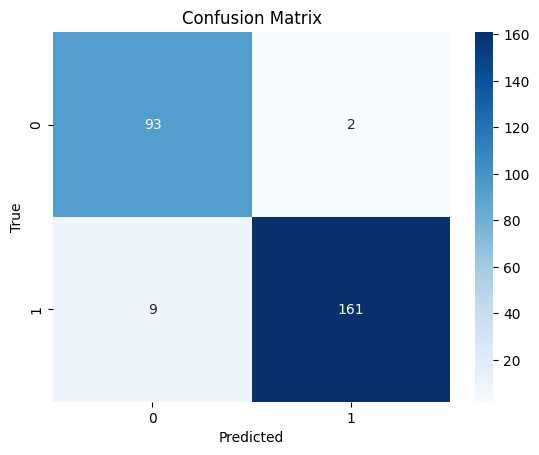

In [ ]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
df_topred = df_topred.iloc[:, :-1]
df_topred = pd.get_dummies(df_topred, columns=['AnimalName'], drop_first=True)
object_columns = df_topred.select_dtypes(include=['object']).columns
for col in object_columns:
    df_topred[col] = pd.to_numeric(df_topred[col], errors='coerce')
df_topred = df_topred.reindex(columns=X.columns, fill_value=0)


In [ ]:
pred = model.predict(df_topred)
pred

array([1, 1])